# Ordering of image sequences based on similarity values

# Table of Contents
* [General](#first-bullet)
* [Load paths](#second-bullet)
* [Load model](#third-bullet)
* [Order images](#fourth-bullet)
* [Plot ordered indices](#fifth-bullet)

# General <a class="anchor" id="first-bullet"></a>

General imports and class definitions

In [6]:
%load_ext autoreload
%autoreload 2

Load paths from config file

In [7]:
from twinnet_tools.tnconfig import ProjectConfig

config = ProjectConfig("twinnet_config")

ProjectConfig: /root/capsule/code/Scripts/twinnet_config/Linux/config.json


In [8]:
dir_root_scripts = config.json["dir_scripts"]

path_model_zebrafish = config.json["dir_model_zebrafish_original"]

config_paths_script = config.json["Image_ordering"]

dir_src_e1 = config_paths_script["dir_data_src_e1"]

dir_src_indices_reference_e1 = config_paths_script["dir_data_src_reference"]

dir_dst = config_paths_script["dir_data_dst"]

Import Python packages

In [9]:
import glob
import matplotlib as mpl
import numpy as np
import os
import random
import sys

from pathlib import Path

sys.path.append(dir_root_scripts)
from twinnet_tools.tngeneral import TNToolsGeneral
from twinnet_tools.tnmodel import TNToolsNetwork
from twinnet_tools.tnorder import DataInferenceTemporalSequenceTN, OrderTemporalSequenceTN, PlotTemporalSequenceTN

Prepare class instances

In [10]:
tools_general = TNToolsGeneral()
tools_model = TNToolsNetwork()
tools_order_sequence = DataInferenceTemporalSequenceTN()
tools_order_plot = PlotTemporalSequenceTN()

Adjust matplotlib parameters to save plots as .svg files.

In [11]:
new_rc_params = {'text.usetex': False,
                 'svg.fonttype': 'none',
                 'lines.linewidth': 1}

mpl.rcParams.update(new_rc_params)

# Load paths <a class="anchor" id="second-bullet"></a>

In [12]:
dir_dst_path = Path( dir_dst )
dir_dst_path.mkdir(parents=True, exist_ok=True)

Load test data paths

In [13]:
dir_e1_ss_02 = dir_src_e1 + "_step_size_002"
dir_e1_ss_03 = dir_src_e1 + "_step_size_003"
dir_e1_ss_04 = dir_src_e1 + "_step_size_004"
dir_e1_ss_05 = dir_src_e1 + "_step_size_005"
dir_e1_ss_10 = dir_src_e1 + "_step_size_010"
dir_e1_ss_20 = dir_src_e1 + "_step_size_020"

In [14]:
dir_e1_ss_reference_indices = dir_src_indices_reference_e1 + \
    "/indices_sorting_original_reindexed.txt"
dir_e1_ss_02_reference_indices = dir_src_indices_reference_e1 + \
    "_step_size_002/indices_sorting_original_reindexed.txt"
dir_e1_ss_03_reference_indices = dir_src_indices_reference_e1 + \
    "_step_size_003/indices_sorting_original_reindexed.txt"
dir_e1_ss_04_reference_indices = dir_src_indices_reference_e1 + \
    "_step_size_004/indices_sorting_original_reindexed.txt"
dir_e1_ss_05_reference_indices = dir_src_indices_reference_e1 + \
    "_step_size_005/indices_sorting_original_reindexed.txt"
dir_e1_ss_10_reference_indices = dir_src_indices_reference_e1 + \
    "_step_size_010/indices_sorting_original_reindexed.txt"
dir_e1_ss_20_reference_indices = dir_src_indices_reference_e1 + \
    "_step_size_020/indices_sorting_original_reindexed.txt"

In [15]:
samples_test = {
    "1-01": (dir_src_e1, dir_e1_ss_reference_indices, 300, 1),
    "1-02": (dir_e1_ss_02, dir_e1_ss_02_reference_indices, 300, 2),
    "1-03": (dir_e1_ss_03, dir_e1_ss_03_reference_indices, 300, 3),
    "1-04": (dir_e1_ss_04, dir_e1_ss_04_reference_indices, 300, 4),
    "1-05": (dir_e1_ss_05, dir_e1_ss_05_reference_indices, 300, 5),
    "1-10": (dir_e1_ss_10, dir_e1_ss_10_reference_indices, 300, 10),
    "1-20": (dir_e1_ss_20, dir_e1_ss_20_reference_indices, 300, 20),
}

# Load model <a class="anchor" id="third-bullet"></a>

In [16]:
tn_model_embedding = tools_model.tn_embedding_load(path_model_zebrafish)

2023-05-09 10:22:07.707304: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 10:22:07.748430: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 10:22:07.751412: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-09 10:22:07.754508: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

# Order images <a class="anchor" id="fourth-bullet"></a>

Prepare methods

In [17]:
def step1_images_load(dir_src):
    """
    Load image paths from directory.
    """
    # 1. Dir src -> load image src paths
    paths_imgs_src = glob.glob(f'{dir_src}/*.tif')  # Order 1 (original)

    # 2. Image paths -> indexing
    paths_imgs_src = list(enumerate(sorted(paths_imgs_src)))  # Order 1 (original)

    # 3. Tuples (original indices, image paths) -> shuffle
    random.seed(1)
    random.shuffle(paths_imgs_src)  # Order 2 (Shuffled)
    return paths_imgs_src
    
def step2_embeddings_calculate(paths_imgs_src):
    """
    Load images and calculate embeddings.
    """
    # 4. Shuffled tuples (original indices, image paths) -> split into shuffled indices, shuffled paths
    indices_imgs_src_shuffled = [index for index,_ in paths_imgs_src]  # Order 2 (shuffled) indices of paths
    paths_imgs_src_shuffled = [img for _, img in paths_imgs_src]  # Order 2 (shuffled)

    # 5. Shuffled tuples (original indices, image paths) -> embeddings
    embeddings_src = tools_order_sequence.list_to_embeddings(paths_imgs_src_shuffled, tn_model_embedding)  # Order 2 (shuffled)
    return embeddings_src, indices_imgs_src_shuffled

def step3_embeddings_order(embeddings_src, indices_imgs_src_shuffled):
    """
    Order embeddings based on similarities and create a list
    of the indices of the embeddings in the predicted order.
    Use this list of the embedding indices to access original
    indices.
    Return a list with the indices of the input paths in the
    predicted order.
    """
    # 6. Shuffled image paths -> encode order in list of indices of original shuffled indices that are supposedly in order
    tool_order = OrderTemporalSequenceTN(embeddings_src)
    values_ordered = tool_order()  # Order 3 indices of Order 2 indices

    idxs_ordered = [values_ordered[i]['idx_ordered'] for i in values_ordered.keys()]
    sums_zscores = [values_ordered[i]['sum_zscores'] for i in values_ordered.keys()]
    nums_nonmax = [values_ordered[i]['num_nonmax'] for i in values_ordered.keys()]

    print(f'Starting at index {np.argmax(sums_zscores)} led to highest sum of z-scores.')
    print(f'Starting at index {np.argmin(nums_nonmax)} led to lowest number of non-maximum similarity assignments.')
    start_index_nonmax_based = int(np.argmin(nums_nonmax))
    
    # 7. Encoded ordered indices of indices -> decoded indices of paths
    indices_decoded = [indices_imgs_src_shuffled[i] for i in idxs_ordered[start_index_nonmax_based]]
    
    return indices_decoded

def image_ordering_pipeline(dir_src):
    """
    Order images within a directory based on similarity values.
    """
    paths_imgs_src = step1_images_load(dir_src)
    embeddings_src, indices_imgs_src_shuffled = step2_embeddings_calculate(paths_imgs_src)
    indices_decoded = step3_embeddings_order(embeddings_src, indices_imgs_src_shuffled)
    return indices_decoded

Order images

In [18]:
indices_ordered = {"e1": dict()}
deviations = {"e1": dict()}
derivs_order = {"e1": dict()}

for _k, _v in samples_test.items():
    print(f'No.: {_k}')
    
    # Get prediction of index ordering from TN
    indices_decoded = image_ordering_pipeline(_v[0])

    # Load prediction of index ordering of Dsilva et al. 2015 method
    idxs_order_reference = tools_order_sequence.indices_reference_load(_v[1])

    # Make a linear fitting of the data to check if ordering has negative or positive slope.
    values_x = list(range(0, _v[2], _v[3]))
    reverse_test = tools_order_sequence.fn_fit_linear(values_x, indices_decoded)
    reverse_reference = tools_order_sequence.fn_fit_linear(values_x, idxs_order_reference)

    # Reverse indices if necessary
    indices_decoded, idxs_order_reference = tools_order_sequence.fn_indices_reverse(
        indices_decoded, idxs_order_reference, reverse_test=reverse_test, reverse_reference=reverse_reference)
    
    # Save ordered indices to dictionary 'indices_ordered'
    indices_ordered[f"e{_k[0]}"][_k] = (indices_decoded, idxs_order_reference, _v[2], _v[3])
    
    # Calculate deviation from ground truth
    dev_tn, dev_ref = tools_order_sequence.deviation_temporal_average_calculate(indices_decoded, idxs_order_reference, _v[2], _v[3])
    deviations[f"e{_k[0]}"][_k] = (dev_tn, dev_ref)
    
    # Calculate derivative of timepoint ordering, i.e. slope of index changes
    deriv_tn, deriv_ref = tools_order_sequence.temporal_ordering_derivation(indices_decoded, idxs_order_reference)
    derivs_order[f"e{_k[0]}"][_k] = (deriv_tn, deriv_ref)
    
    print(f"{_k}: tn {np.mean(dev_tn)} ref {np.mean(dev_ref)}".ljust(10), end='\n')

No.: 1-01


2023-05-09 10:22:15.955963: W tensorflow_io/core/kernels/audio_video_mp3_kernels.cc:271] libmp3lame.so.0 or lame functions are not available
2023-05-09 10:22:15.956271: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 AVX512F FMA


[DONE][Images] 0300/0300                          


2023-05-09 10:22:18.949692: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


[DONE][Embeddings] 0015/0015                      
[INFO] Number of 256-dimensional arrays: 300
[DONE][Similarities] 44850/44850                  
[DONE][Orderings] 0300/0300                       
Starting at index 201 led to highest sum of z-scores.
Starting at index 153 led to lowest number of non-maximum similarity assignments.
1-01: tn 51.833333333333336 ref 52.39333333333333
No.: 1-02
[DONE][Images] 0150/0150                          
[DONE][Embeddings] 0008/0008                      
[INFO] Number of 256-dimensional arrays: 150
[DONE][Similarities] 11175/11175                  
[DONE][Orderings] 0150/0150                       
Starting at index 134 led to highest sum of z-scores.
Starting at index 9 led to lowest number of non-maximum similarity assignments.
1-02: tn 79.2 ref 107.49333333333334
No.: 1-03
[DONE][Images] 0100/0100                          
[DONE][Embeddings] 0005/0005                      
[INFO] Number of 256-dimensional arrays: 100
[DONE][Similarities] 4950/495

## Plot ordered indices <a class="anchor" id="fifth-bullet"></a>

In [24]:
from IPython.display import HTML, Image,SVG,display

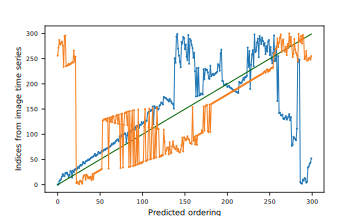

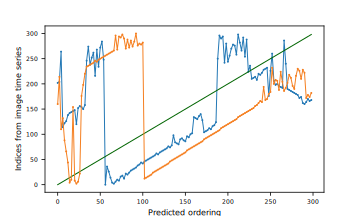

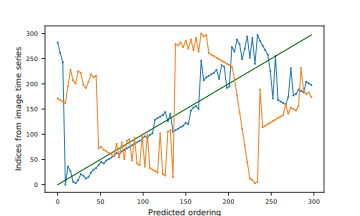

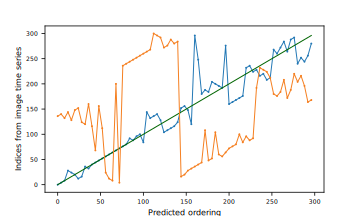

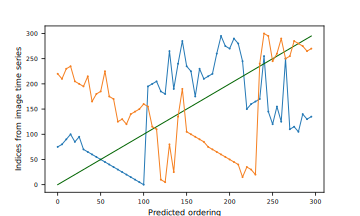

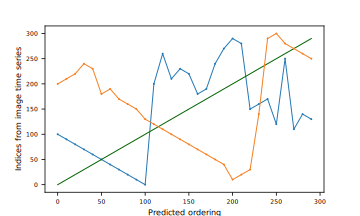

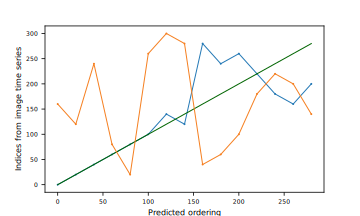

In [28]:
embryo_name_original = {
    "e1": "0049--B003--PO35--E005",
}

for _k_e, _v_e in indices_ordered.items():
    _n_e = embryo_name_original[_k_e]
    for _k_stepsize, _v_stepsize in _v_e.items():
        display( HTML(f'<h3>Stepsize {_k_stepsize}</h3>') )
        path_save = os.path.join(
            dir_dst,
            f'evaluation_methods_{str(_n_e)}' \
            f'_stepsize_{str(_k_stepsize[-2:]).zfill(3)}.svg')

        # Plot predictions of index orderings
        tools_order_plot.plot_ordering(_v_stepsize[0],
                                _v_stepsize[1],
                                _v_stepsize[3],
                                _v_stepsize[2], 
                                savefig=path_save,
                                title='Predicted ordering')
        
        
        display(SVG(filename=path_save))
        

Compare deviation from ground truth with reference model

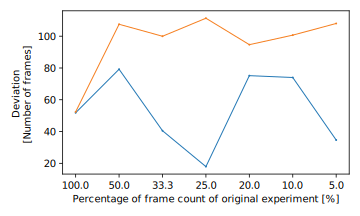

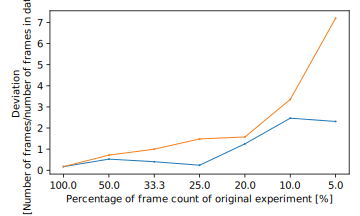

In [21]:
tools_order_plot.deviation_avg_plot(deviations["e1"], 300, absolute=True, savefig=f'{dir_dst}/deviation_plot_frames.svg')

display(SVG(filename=f'{dir_dst}/deviation_plot_frames.svg'))

tools_order_plot.deviation_avg_plot(deviations["e1"], 300, absolute=False, savefig=f'{dir_dst}/deviation_plot_part.svg')

display(SVG(filename=f'{dir_dst}/deviation_plot_part.svg'))